# <a id='toc1_'></a>[EDA](#toc0_)

"""
Created on Fri Jun 30 14:36:03 2023

@author: Nima
"""


**Table of contents**<a id='toc0_'></a>    
- [EDA](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
  - [1.1. Key Questions](#toc2_2_)    
  - [1.2. Assumptions and Methods](#toc2_3_)    
  - [1.3. Setup and Data Collection](#toc2_4_)    
- [2. Exploratory Data Analysis](#toc3_)    
  - [2.1. Price Distribution](#toc3_1_)    
  - [2.2. Availability_365](#toc3_2_)    
    - [By Neighbourhood](#toc3_2_1_)    
    - [Room type and availability](#toc3_2_2_)    
  - [2.3. Distribution Room Type](#toc3_3_)    
  - [2.4. Reviews](#toc3_4_)    
  - [2.5. Concentration of AirBnB](#toc3_5_)    
  - [2.6 Price and Neighbourhood](#toc3_6_)    
    - [Price and neighbourhood by bedroom category](#toc3_6_1_)    
- [3. Solving price distribution](#toc4_)    
    - [add](#toc4_1_1_)    
    - [Other distribution](#toc4_1_2_)    
    - [Filling null/ no review with mean](#toc4_1_3_)    
    - [Normalize the distribution](#toc4_1_4_)    
- [5. Save Transformations](#toc5_)    
- [4. Linear Correlation between LogPrice and NumColumns](#toc6_)    
- [6. Key Findings](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)



## <a id='toc2_2_'></a>[1.1. Key Questions](#toc0_)

In this notebook, we are trying to get descriptive information from the dataset. I display the knowledge gain from analysis the data to some visual. I will also use this knowledge to modify the dataset in the third section. 

Finally I'm also looking at some of the linear modeling assumptions.

## <a id='toc2_3_'></a>[1.2. Assumptions and Methods](#toc0_)


## <a id='toc2_4_'></a>[1.3. Setup and Data Collection](#toc0_)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from folium.plugins import HeatMap
import os

In [15]:
csv_path = '../../GitHub/Capstone/1_dpp_airbnb_vancouver.csv'

if os.path.isfile(csv_path):
    df_subset = pd.read_csv(csv_path)
    exec(open('..\\..\\GitHub\\Capstone\\0_config.py').read())
    df_subset['first_review'] = pd.to_datetime(df_subset['first_review']) # CSV does not saved it as a date
    df_subset['last_review'] = pd.to_datetime(df_subset['last_review'])
    df_subset['host_since'] = pd.to_datetime(df_subset['host_since'])
    print('CSV file read successfully.')
else:
    exec(open('..\\..\\GitHub\\Capstone\\1_DataPreProcessing.ipynb').read())
    print('File execution completed.')

CSV file read successfully.



# <a id='toc3_'></a>[2. Exploratory Data Analysis](#toc0_)

In this section, we will perform some basic data analysis.



## <a id='toc3_1_'></a>[2.1. Price Distribution](#toc0_)

In [163]:
df_subset['price'].describe()
# it goes from 14 to 77k dollars!

count     5975.000000
mean       217.421757
std       1087.709532
min         14.000000
25%        101.000000
50%        149.000000
75%        219.000000
max      77178.000000
Name: price, dtype: float64

<Axes: >

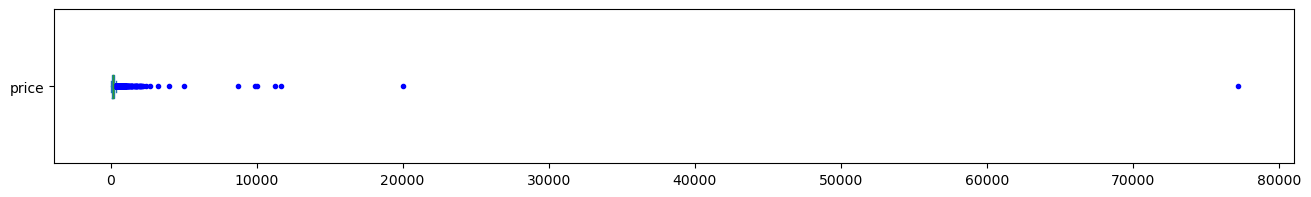

In [164]:
# Price Distribution plot
price_boxplot = dict(markerfacecolor='b', markeredgecolor='b', marker='.')
df_subset['price'].plot(kind='box',  vert=False, flierprops=price_boxplot, figsize=(16,2))

We can see clearly that there are mainly outliers

In [165]:
# Removing outliers
mean = df_subset['price'].mean()
std = df_subset['price'].std()
upper_limit = mean + 3 * std #3-sigma rules
df_subset = df_subset[df_subset['price'] <= upper_limit]

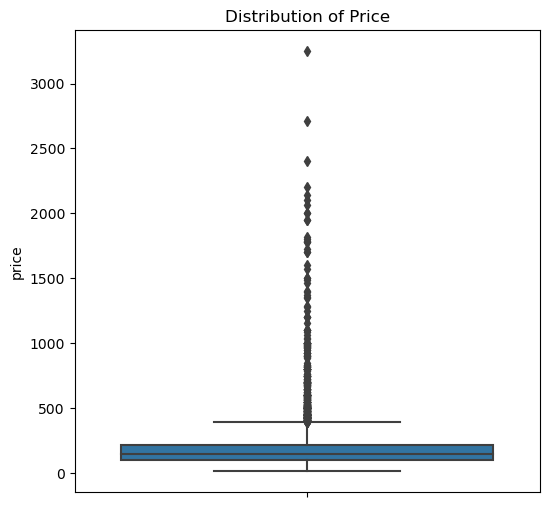

In [166]:
# Price distribution after removing most of the outliers
plt.figure(figsize=(6,6))
sns.boxplot(y=df_subset['price'])
plt.title("Distribution of Price")
plt.show()

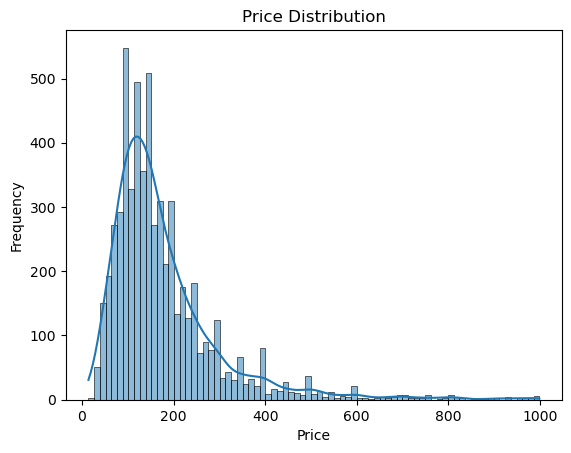

In [167]:
# Price frequency (below 1000 for ease of visualization)
sns.histplot(data=(df_subset[df_subset['price'] < 1000]), x='price', kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

It can be seen that prices are mostly around between 100 and 200 dollars. Price data is right skewed.


## <a id='toc3_2_'></a>[2.2. Availability_365](#toc0_)

In [168]:
df_subset.availability_365.describe()

count    5966.000000
mean      139.163426
std       120.677209
min         0.000000
25%        31.250000
50%       105.000000
75%       236.000000
max       365.000000
Name: availability_365, dtype: float64

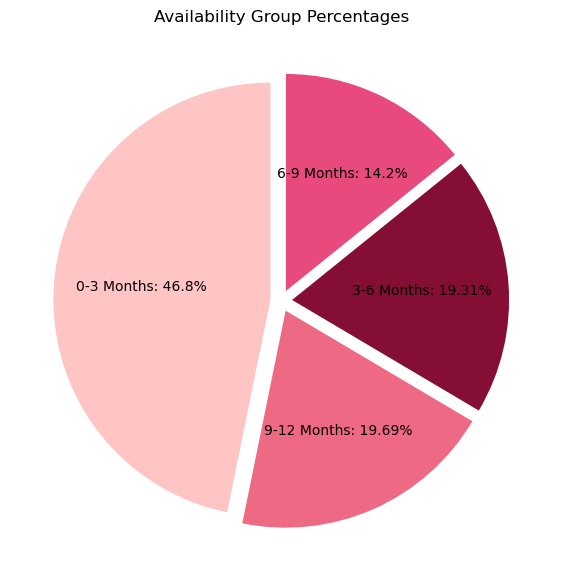

In [169]:
# Availability per trimestre
# make groups every 3 months 
df_subset['availability_grp'] = np.where(df_subset.availability_365<=90, '0-3 Months',
                   np.where((df_subset.availability_365 > 9) & (df_subset.availability_365 <= 180), '3-6 Months',
                   np.where((df_subset.availability_365 > 180) & (df_subset.availability_365 <= 270), '6-9 Months', '9-12 Months')))

df_subset['availability_grp'].value_counts()

# Calculate availability_grp percentages
availability_grp_counts = df_subset['availability_grp'].value_counts()
availability_grp_percentages = round(availability_grp_counts / df_subset.shape[0] * 100, 2)

# Define category labels
categories = availability_grp_counts.index.tolist()

# Plot pie chart
fig, ax = plt.subplots(figsize=(7, 10))
explode = (0.05, 0.05, 0.05, 0.05)
colors = ['#FFC4C4', '#EE6983', '#850E35', '#e84a7e']
_, _, autotexts = ax.pie(availability_grp_percentages, explode=explode, colors=colors,
                         autopct='%1.1f%%', startangle=90)

# Add category labels as annotations
for i, category in enumerate(categories):
    autotexts[i].set_text(f'{category}: {availability_grp_percentages[i]}%')

ax.set(aspect="equal", title="Availability Group Percentages")

# Show the plot
plt.show()


A Large majority of the rental in Vancouver are available between 0-3 months for the upcoming year


### <a id='toc3_2_1_'></a>[By Neighbourhood](#toc0_)

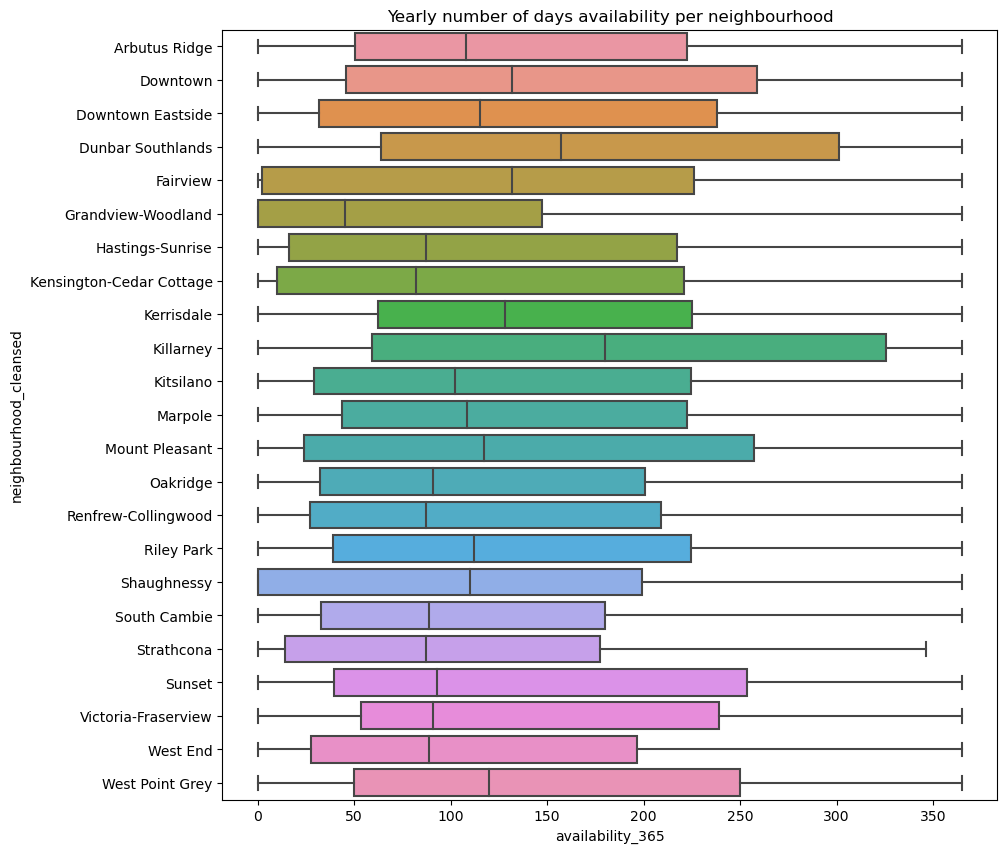

In [171]:
# Order the neighbourhoods alphabetically
neighbourhood_order = df_subset.neighbourhood_cleansed.sort_values().unique()

plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=df_subset, y='neighbourhood_cleansed', x='availability_365', order=neighbourhood_order)

# Add title
plt.title('Yearly number of days availability per neighbourhood')
plt.show()

The 'availability_365' column shows that the availability of rooms per year ranges from 0 to 365 days across all neighborhoods.

The median, the 25th and 75th quantile and the variance across neighbourdhood varies significantly Availability_365 can be interpreted of two differents ways, which are conflicting.

A low availability could mean a highly booked property. However it could also represents a property, which is not rented all year long

### <a id='toc3_2_2_'></a>[Room type and availability](#toc0_)

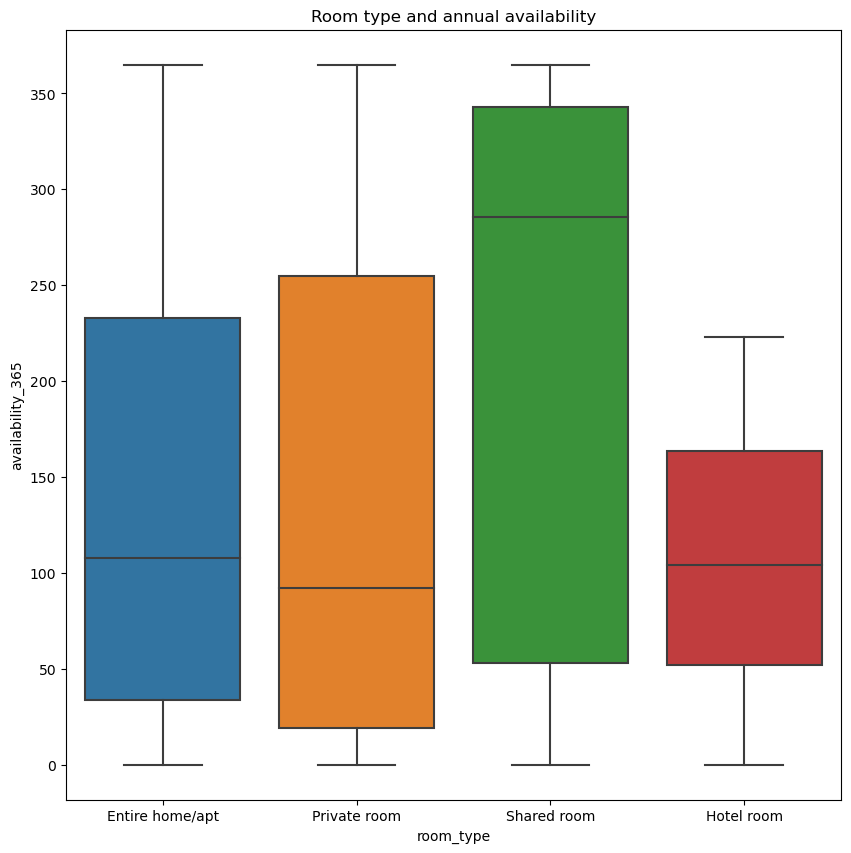

In [172]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df_subset, x='room_type',y='availability_365')
plt.title('Room type and annual availability')
plt.show()

The variance goes from min to max respectivally: from hotel room, entire home/ aprt, private room to  shared room. 

This means that the hotel room are safer investivement, while shared rooms tend to have a higher spread of numbers of days available

However, as mentioned earlier, a high variance in shared room could be seen as some room are on the market only a few days per year if the original renter is in that room as well. Other rooms may be on the market all year.  This will impact the 365_availability


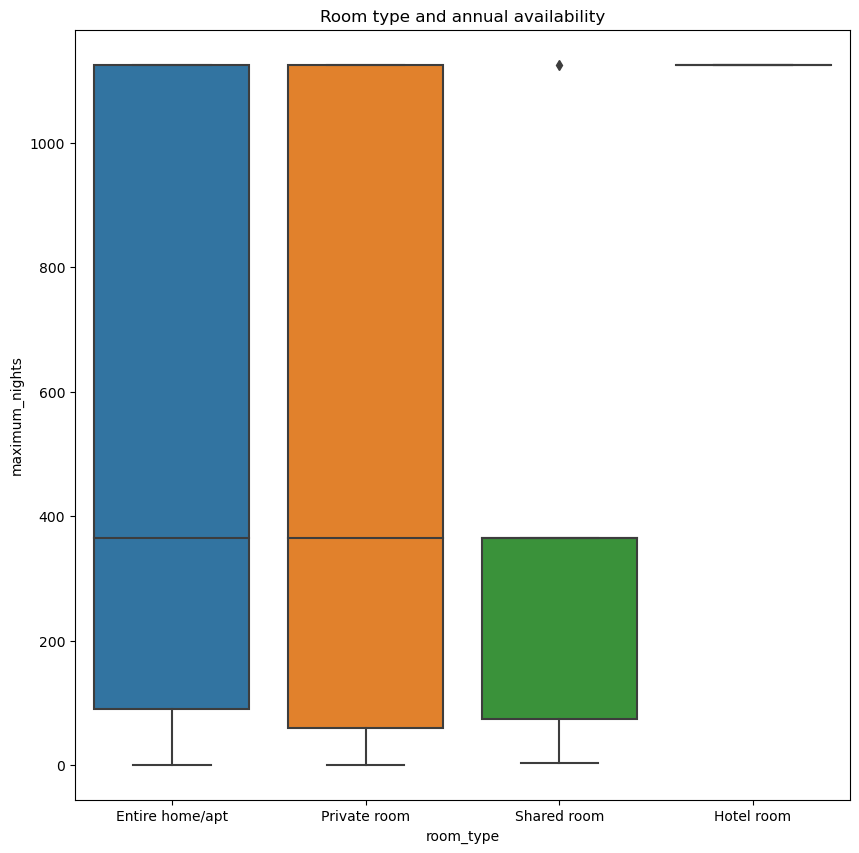

,min,max
room_type,,
Entire home/apt,1,1125
Hotel room,1125,1125
Private room,1,1125
Shared room,4,1125


In [173]:
#We could confirm this assumption by looking at the maximum rental per room type
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df_subset, x='room_type',y='maximum_nights')
plt.title('Room type and annual availability')
plt.show()

df_subset.groupby('room_type')['maximum_nights'].agg(['min', 'max'])

This is not exactly what I was expecting. The maximum of days can exceed one year. 

As we can see entire home/apt and private room seems to have a system cap of 3 years. 

There is however no business reason for caping a rental of a private appartment/ room for a year maximum.


## <a id='toc3_3_'></a>[2.3. Distribution Room Type](#toc0_)

In [174]:
df_subset['room_type'].value_counts()

Entire home/apt    4914
Private room       1023
Shared room          26
Hotel room            3
Name: room_type, dtype: int64

A majority of the Airbnb are of the type Entire home/apt, while we only have 3 hotel room and 26 shared room.

Hotel and Shared room are underrepresented in the dataset compared to 'Entire home/apt' and 'Private room', it might introduce imbalance in the data if I keep, which can potentially impact the performance and generalization of my models

In [175]:
# So I will drop them
df_subset = df_subset[~df_subset['room_type'].isin(['Shared room', 'Hotel room'])]

df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5937 entries, 0 to 5974
Data columns (total 76 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  5937 non-null   int64  
 1   name                                5937 non-null   int64  
 2   description                         5937 non-null   int64  
 3   neighborhood_overview               5937 non-null   int64  
 4   host_id                             5937 non-null   int64  
 5   host_since                          5937 non-null   object 
 6   host_about                          5937 non-null   int64  
 7   host_response_time                  5937 non-null   object 
 8   host_response_rate                  4836 non-null   float64
 9   host_acceptance_rate                5077 non-null   float64
 10  host_is_superhost                   5937 non-null   int64  
 11  host_listings_count                 5937 no


## <a id='toc3_4_'></a>[2.4. Reviews](#toc0_)

In [176]:
df_subset.number_of_reviews.describe()

count    5937.000000
mean       37.798046
std        67.982352
min         0.000000
25%         2.000000
50%        10.000000
75%        44.000000
max       863.000000
Name: number_of_reviews, dtype: float64

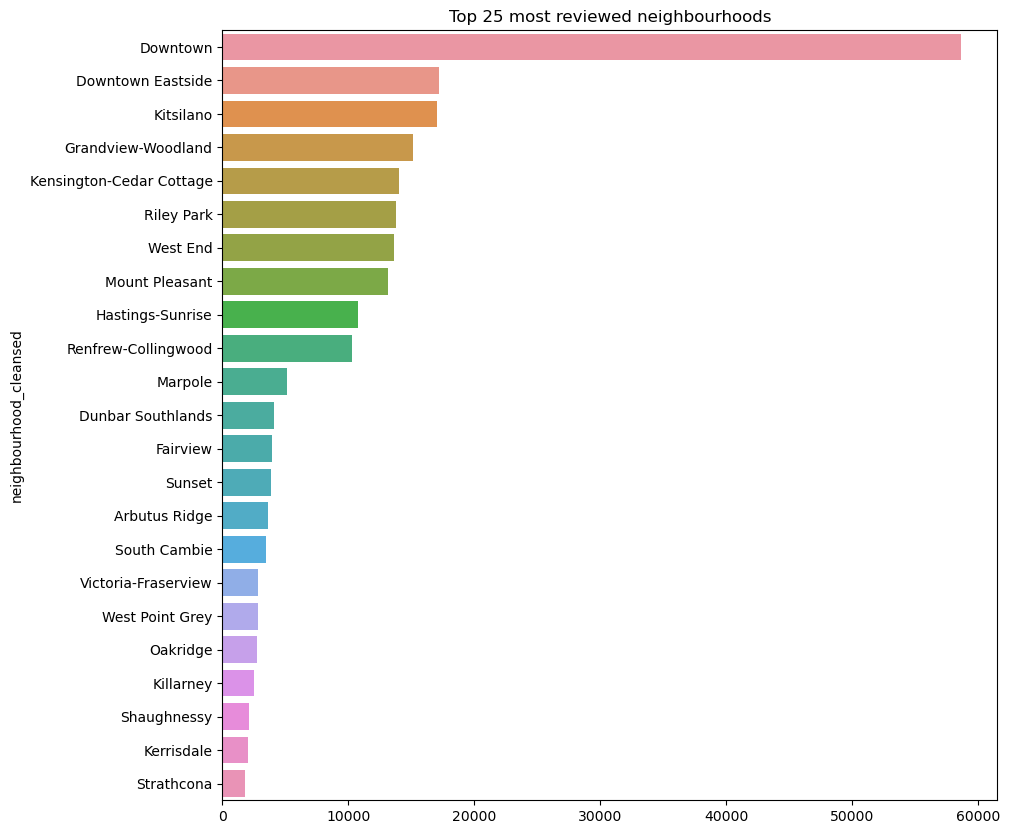

In [177]:
## Who is Top 25 most reviewed neighbourhoods ?

top_25_reviewed_neighbourhoods = df_subset.groupby(['neighbourhood_cleansed'])['number_of_reviews'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,10))
plt.title("Top 25 most reviewed neighbourhoods")
sns.barplot(x=top_25_reviewed_neighbourhoods.values,y=top_25_reviewed_neighbourhoods.index)
plt.show()

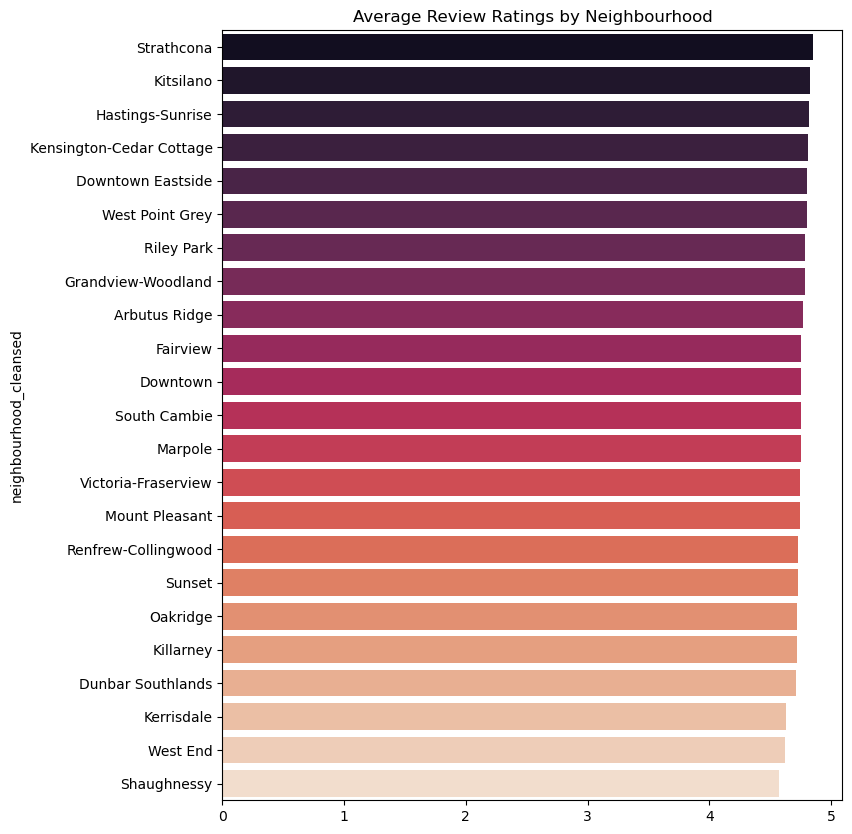

In [178]:
# Review rate number per neighbourdhood
df_subset_with_ratings=df_subset[df_subset['review_scores_rating'] != 'No review']
df_subset_with_ratings.review_scores_rating=df_subset_with_ratings.review_scores_rating.astype(float)

avg_rating_per_neighbourhood = df_subset_with_ratings.groupby(['neighbourhood_cleansed'])['review_scores_rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=avg_rating_per_neighbourhood.values, y=avg_rating_per_neighbourhood.index, palette='rocket')
plt.title("Average Review Ratings by Neighbourhood")
plt.show()

In [179]:
# TODO
# Create a graph with host_response_time, reviews rating, neighbourdhood,host_verification
# Create a figure with subplots
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#fig.subplots_adjust(hspace=0.4)

# Plot 1: Bar plot of host_response_time
#axs[0, 0].bar(df_subset_with_ratings['host_response_time'].value_counts().index, df_subset_with_ratings['host_response_time'].value_counts())
#axs[0, 0].set_title('Host Response Time')
#axs[0, 0].set_xlabel('Response Time')
#axs[0, 0].set_ylabel('Count')

# Plot 2: Scatter plot of reviews_rating vs. neighbourhood
#axs[0, 1].scatter(df_subset_with_ratings['review_scores_rating'], df_subset_with_ratings['neighbourhood_cleansed'])
#axs[0, 1].set_title('Reviews Rating vs. Neighbourhood')
#axs[0, 1].set_xlabel('Reviews Rating')
#axs[0, 1].set_ylabel('Neighbourhood')

# Plot 3: Bar plot of neighbourhood
#axs[1, 0].bar(df_subset_with_ratings['neighbourhood_cleansed'].value_counts().index, df_subset_with_ratings['neighbourhood_cleansed'].value_counts())
#axs


## <a id='toc3_5_'></a>[2.5. Concentration of AirBnB](#toc0_)

In [180]:
data_map=df_subset[['latitude','longitude']]
loc_center = [data_map['latitude'].mean(), data_map['longitude'].mean()]
airbnb_density=folium.Map(location=loc_center,zoom_start=13)

HeatMap(df_subset[['latitude','longitude']],radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(airbnb_density)
display(airbnb_density)

Downtown certainly has the greatest number of Airbnb
Kitsilano, Mount Pleasant/ False Creek and the West End comes in second position

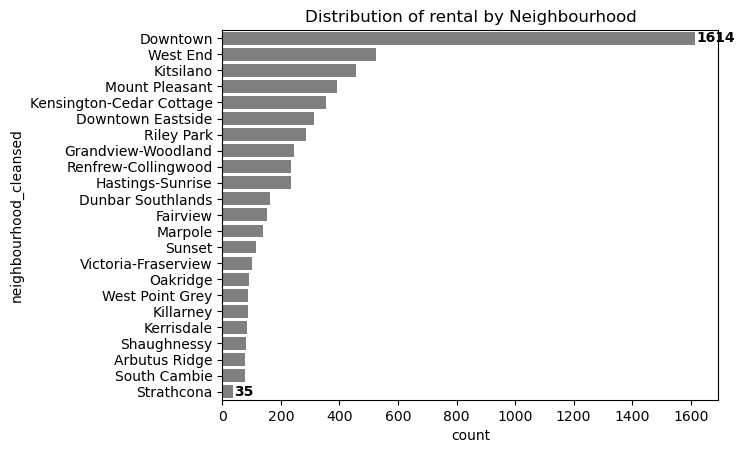

In [181]:
# The number behind the visual:
neighborhood_counts = df_subset['neighbourhood_cleansed'].value_counts().sort_values(ascending=False)

sns.countplot(y='neighbourhood_cleansed', data=df_subset, order=neighborhood_counts.index, color='gray')

 # Add minimum and maximum value annotations
min_value = neighborhood_counts.min()
max_value = neighborhood_counts.max()

for i, count in enumerate(neighborhood_counts):
     if count == min_value or count == max_value:
         plt.annotate(f'{count}', xy=(count, i), xytext=(count + 5, i), va='center', color='black', fontweight='bold')

plt.title("Distribution of rental by Neighbourhood")
plt.show()


## <a id='toc3_6_'></a>[2.6 Price and Neighborhood](#toc0_)

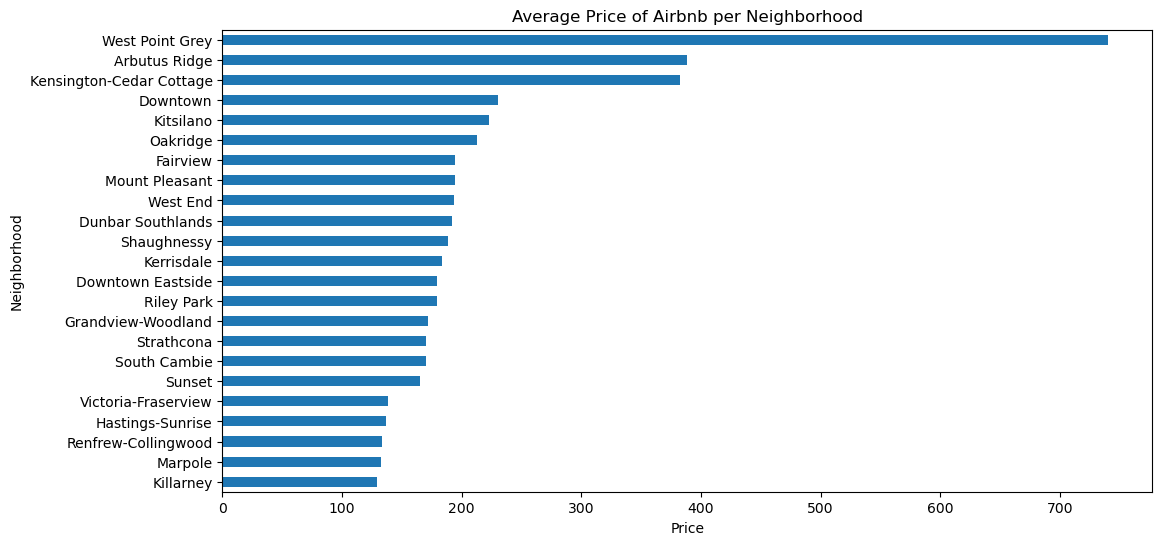

In [16]:
# Group the data by neighborhood and calculate the mean price
neighborhood_prices = df_subset.groupby('neighbourhood_cleansed')['price'].mean()

# Sort the neighborhoods by price in ascending order
neighborhood_prices = neighborhood_prices.sort_values(ascending=True)

# Plot the data
plt.figure(figsize=(12, 6))
neighborhood_prices.plot(kind='barh')
plt.xlabel('Price')
plt.ylabel('Neighborhood')
plt.title('Average Price of Airbnb per Neighborhood')
plt.show()

In average, the most expensive Airbnb are located in West-Point Grey. While it's a luxurious neighbourhood in Vancouver, I'm expecting the type of property and the number of bedrooms available are largely influencing the calculation. So we limited to 2 bedrooms in private property for the next visual to having a base line for the comparison.

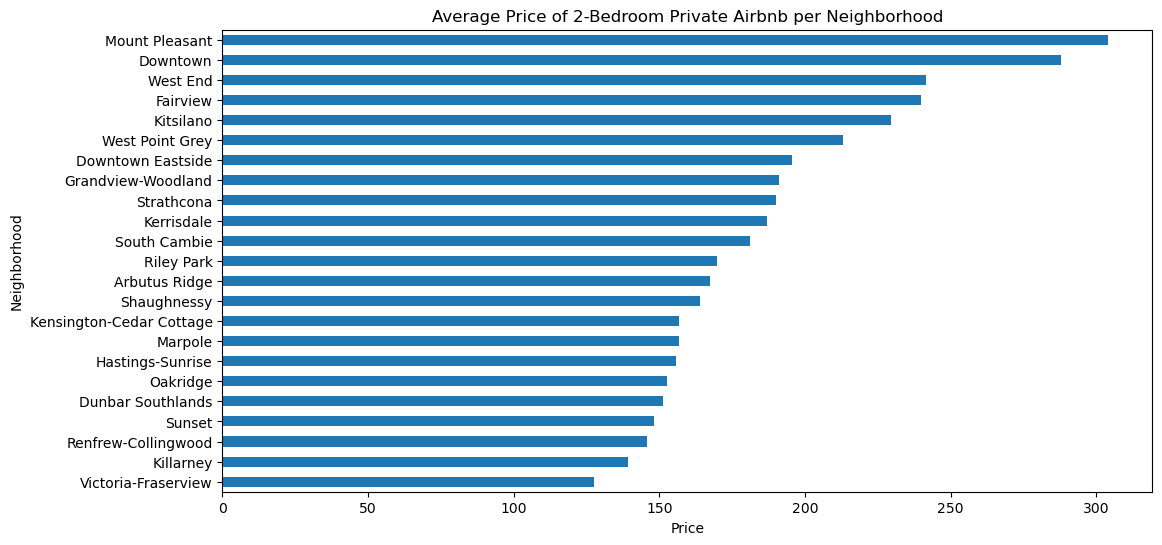

In [23]:
# Subset the DataFrame by bedrooms and room_type
df_subset_filtered = df_subset[(df_subset['bedrooms'] == 2) & (df_subset['room_type'] == 'Entire home/apt')]

# Group the data by neighborhood and calculate the mean price
neighborhood_prices = df_subset_filtered.groupby('neighbourhood_cleansed')['price'].mean()

# Sort the neighborhoods by price in ascending order
neighborhood_prices = neighborhood_prices.sort_values(ascending=True)

# Plot the data
plt.figure(figsize=(12, 6))
neighborhood_prices.plot(kind='barh')
plt.xlabel('Price')
plt.ylabel('Neighborhood')
plt.title('Average Price of 2-Bedroom Private Airbnb per Neighborhood')
plt.show()

The top 3 surely makes sense in Vancouver. They are all along the seawalk, which is a major touristic attraction

### <a id='toc3_6_1_'></a>[Price and neighbourhood by bedroom category](#toc0_)

In [25]:
# Aggregating neighbordhood by 'district'
neighborhood_mapping = {
    'Arbutus Ridge': 'West Side',
    'Downtown': 'Downtown',
    'Downtown Eastside': 'Downtown',
    'Dunbar Southlands': 'West Side',
    'Fairview': 'West Side',
    'Grandview-Woodland': 'East Side',
    'Hastings-Sunrise': 'East Side',
    'Kensington-Cedar Cottage': 'East Side',
    'Kerrisdale': 'West Side',
    'Killarney': 'East Side',
    'Kitsilano': 'West Side',
    'Marpole': 'South Vancouver',
    'Mount Pleasant': 'East Side',
    'Oakridge': 'West Side',
    'Renfrew-Collingwood': 'East Side',
    'Riley Park': 'East Side',
    'Shaughnessy': 'West Side',
    'South Cambie': 'West Side',
    'Strathcona': 'East Side',
    'Sunset': 'East Side',
    'Victoria-Fraserview': 'South Vancouver',
    'West End': 'Downtown',
    'West Point Grey': 'West Side'
}
df_subset['neighborhood_mapping'] = df_subset['neighbourhood_cleansed'].map(neighborhood_mapping)


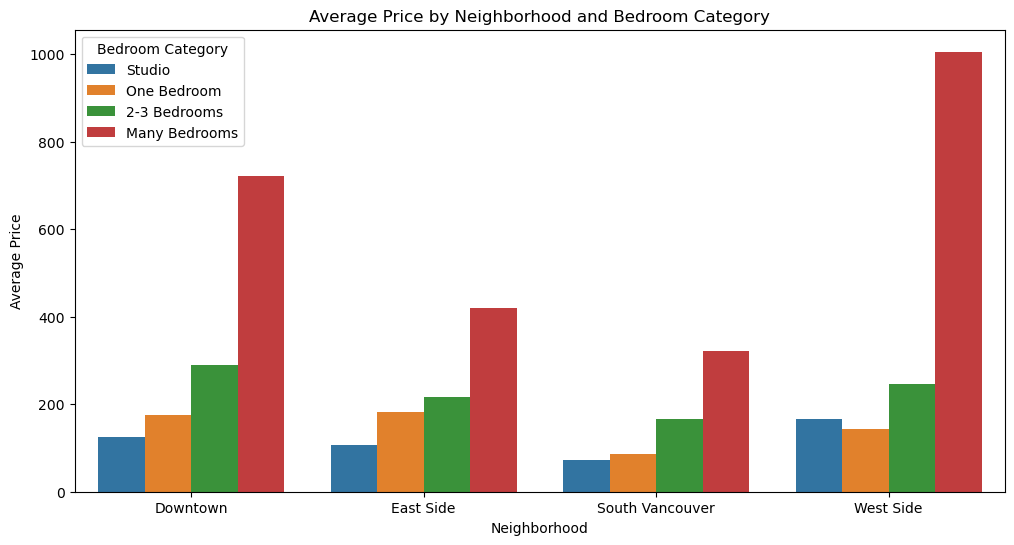

In [26]:
# Group the 'bedrooms' variable into specific categories
df_subset['bedroom_category'] = pd.cut(df_subset['bedrooms'], bins=[-1, 0, 1, 3, df_subset['bedrooms'].max()+1],
                                       labels=['Studio', 'One Bedroom', '2-3 Bedrooms', 'Many Bedrooms'])

# Calculate average price by neighborhood_mapping and bedroom_category
average_data = df_subset.groupby(['neighborhood_mapping', 'bedroom_category']).agg({'price': 'mean'}).reset_index()

# Create grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_data, x='neighborhood_mapping', y='price', hue='bedroom_category')
plt.title('Average Price by Neighborhood and Bedroom Category')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.legend(title='Bedroom Category')

plt.show()

Studio in the West Side charges more on average than in Downtown, while one bedrooms are relatively 'cheap' in comparison.

For airbnb of 2-3 bedrooms, the East Side have prices in range relatively close to the West Side!

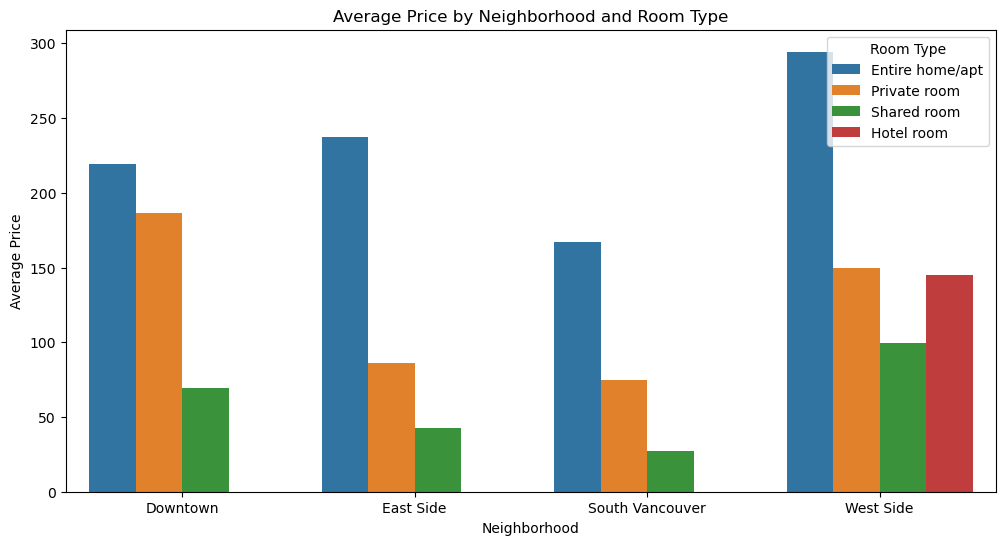

In [28]:
# Calculate average price by neighborhood_mapping and room_type_category
average_data = df_subset.groupby(['neighborhood_mapping', 'room_type']).agg({'price': 'mean'}).reset_index()

# Create grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_data, x='neighborhood_mapping', y='price', hue='room_type')
plt.title('Average Price by Neighborhood and Room Type')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.legend(title='Room Type')

plt.show()

On average, private property rentals in the WestSide command the highest prices in town, reaching almost $300 per night. Downtown follows as the second most expensive area for private property rentals. However, the opposite trend is observed for private rooms, where the WestSide tends to have lower average prices compared to other areas.

### <a id='toc3_6_2_'></a>[Price, neighbourhood and reviews](#toc0_)

C:\Users\Nima\AppData\Local\Temp\ipykernel_10408\214672118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_data.review_scores_rating=sp_data.review_scores_rating.astype(float)


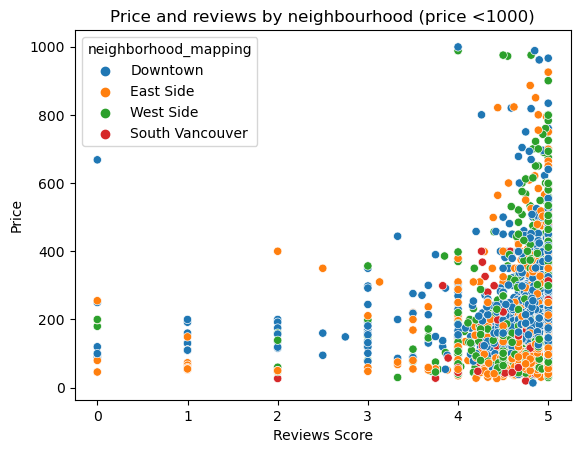

In [30]:
# Creating dataset for scatter plot: removing nan review and price above 1000
sp_data=df_subset[(df_subset['price'] < 1000) & (df_subset['review_scores_rating'] != 'No review')]
sp_data.review_scores_rating=sp_data.review_scores_rating.astype(float)

# Relationship between price and rating for price < 1000 by neighboordhood 'district'
sns.scatterplot(data=sp_data, x='review_scores_rating', y='price', hue='neighborhood_mapping')
plt.title('Price and reviews by neighbourhood (price <1000)')
plt.xlabel('Reviews Score')
plt.ylabel('Price')
plt.show()

We can see that host have an incentive to reduce their price when their review score is low.

Most of the airbnb have a high rating in Vancouver. Among those, the price varies highly. 

However the West Side and Downtown charge the most! 


# <a id='toc4_'></a>[3. Solving price distribution](#toc0_)

We saw earlier that that there is a right-skewed distribution on price. 

This means there is a positive skewness. Log transformation will be used to make this feature less skewed. 

This will help to make easier interpretation and better statistical analysis

C:\Users\Nima\AppData\Local\Temp\ipykernel_12232\834776201.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_subset['log_price'], fit=norm)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

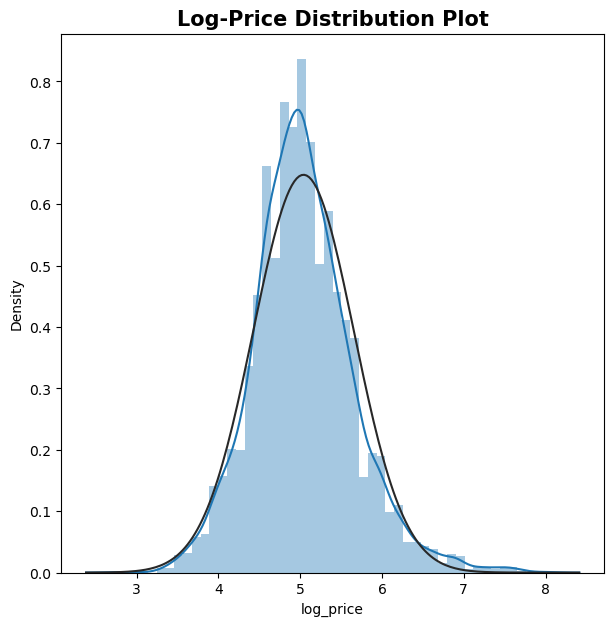

In [185]:
# Calculate the logarithm of total price
df_subset['log_price'] = np.log(df_subset['price']+1)

#Since division by zero is a problem, we do log+1.
#Thanks to log transformation, the price is normaly distributed.

plt.figure(figsize=(7,7))
sns.distplot(df_subset['log_price'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

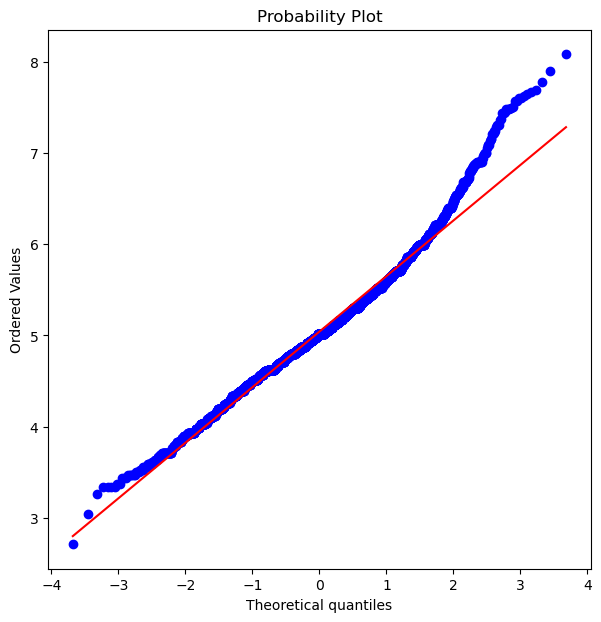

In [186]:
#In below graph, the good fit indicates that normality is a reasonable approximation.
# This is an assumption for applying a linear regression 
plt.figure(figsize=(7,7))
stats.probplot(df_subset['log_price'], plot=plt)
plt.show()


# <a id='toc5_'></a>[4. Solving other distribution issue](#toc0_)


# <a id='toc5_1_'></a>[4.1. Deleting columns with no business meaning](#toc0_)

In [187]:
# Deleting columns having no business meaning
df_subset.drop(['id','host_id','name'], axis=1, inplace=True)


# <a id='toc5_2_'></a>[4.2. Distribution of non-binary numeric column](#toc0_)

In [188]:
# Only numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#Create Corr table between LogPrice and NumColumns
newdf = df_subset.select_dtypes(include=numerics)

# Removing Binary columns
binary_columns = [column for column in newdf.columns if set(newdf[column].unique()) == {0, 1}]
newdf = newdf.drop(binary_columns, axis=1)

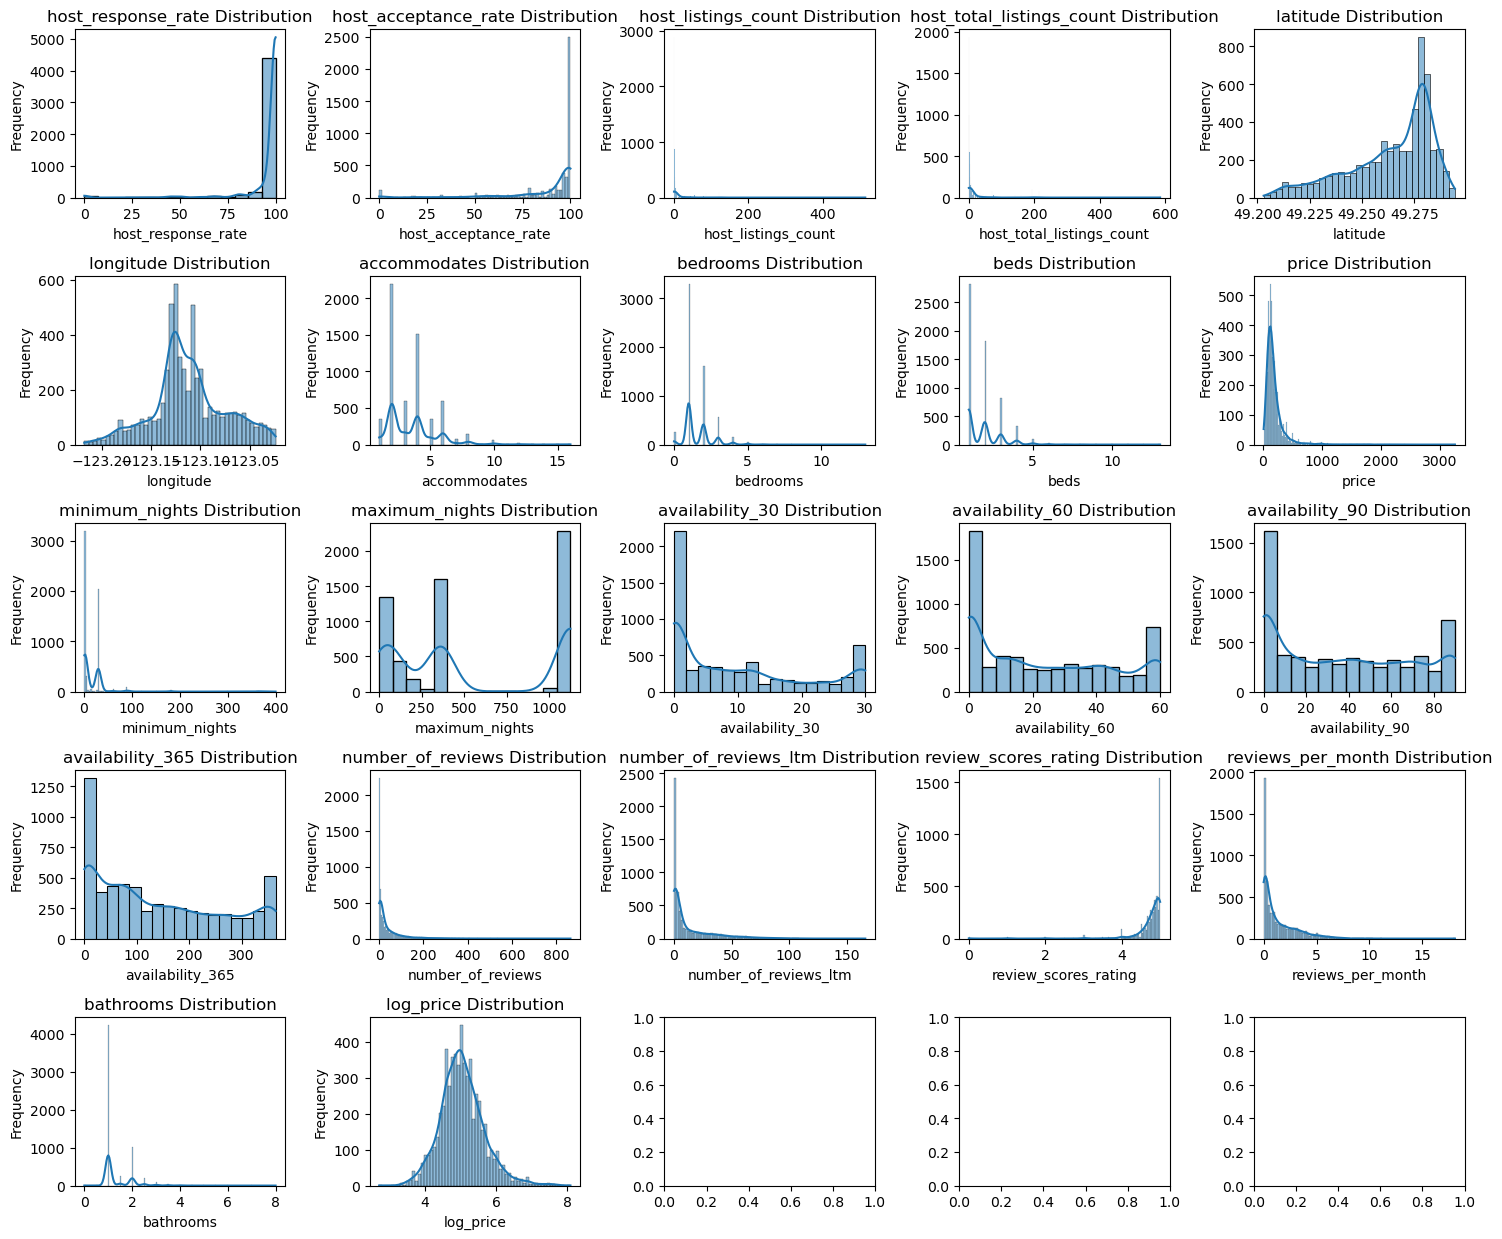

In [189]:
# Create visual 
num_columns = len(newdf.columns)
num_rows = (num_columns + 4) // 5  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 2.5))  # Adjusting figsize

for i, column in enumerate(newdf.columns):
    row = i // 5  # Determine the row index for the subplot
    col = i % 5  # Determine the column index for the subplot

    sns.histplot(data=newdf[column], kde=True, ax=axes[row, col])  # Specify the subplot axes
    axes[row, col].set_title(f"{column} Distribution")
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()  # Adjusting spacing between subplots
plt.show()

As we can see, several columns do not have a normalize distribution. For all of the columns, I will elevate them to their logaritmic

## <a id='toc4_3_'></a>[4.3. Filling null/ no review with mean](#toc0_)

In [190]:
df_subset['host_response_rate'].fillna(df_subset['host_response_rate'].mean(), inplace=True)
df_subset['host_acceptance_rate'].fillna(df_subset['host_acceptance_rate'].mean(), inplace=True)

# Convert 'No review' to Nan and float
df_subset['review_scores_rating']=df_subset['review_scores_rating'].replace('No review', np.nan).astype(float)
# Replace Nan with mean
df_subset['review_scores_rating']=df_subset['review_scores_rating'].fillna(df_subset['review_scores_rating'].mean())

## <a id='toc4_4_'></a>[4.4 Normalizing non-binary numeric variable](#toc0_)

In [191]:
col_to_log = ['host_response_rate','host_acceptance_rate','host_listings_count','host_total_listings_count','accommodates','bedrooms','beds','minimum_nights','maximum_nights','availability_30','availability_60','availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','reviews_per_month','review_scores_rating','bathrooms']
for column in col_to_log:
    df_subset[f"log_{column}"] = np.log(df_subset[column]+1)
    df_subset = df_subset.drop([column], axis=1)

## <a id='toc4_5_'></a>[4.5 New Distribution](#toc0_)

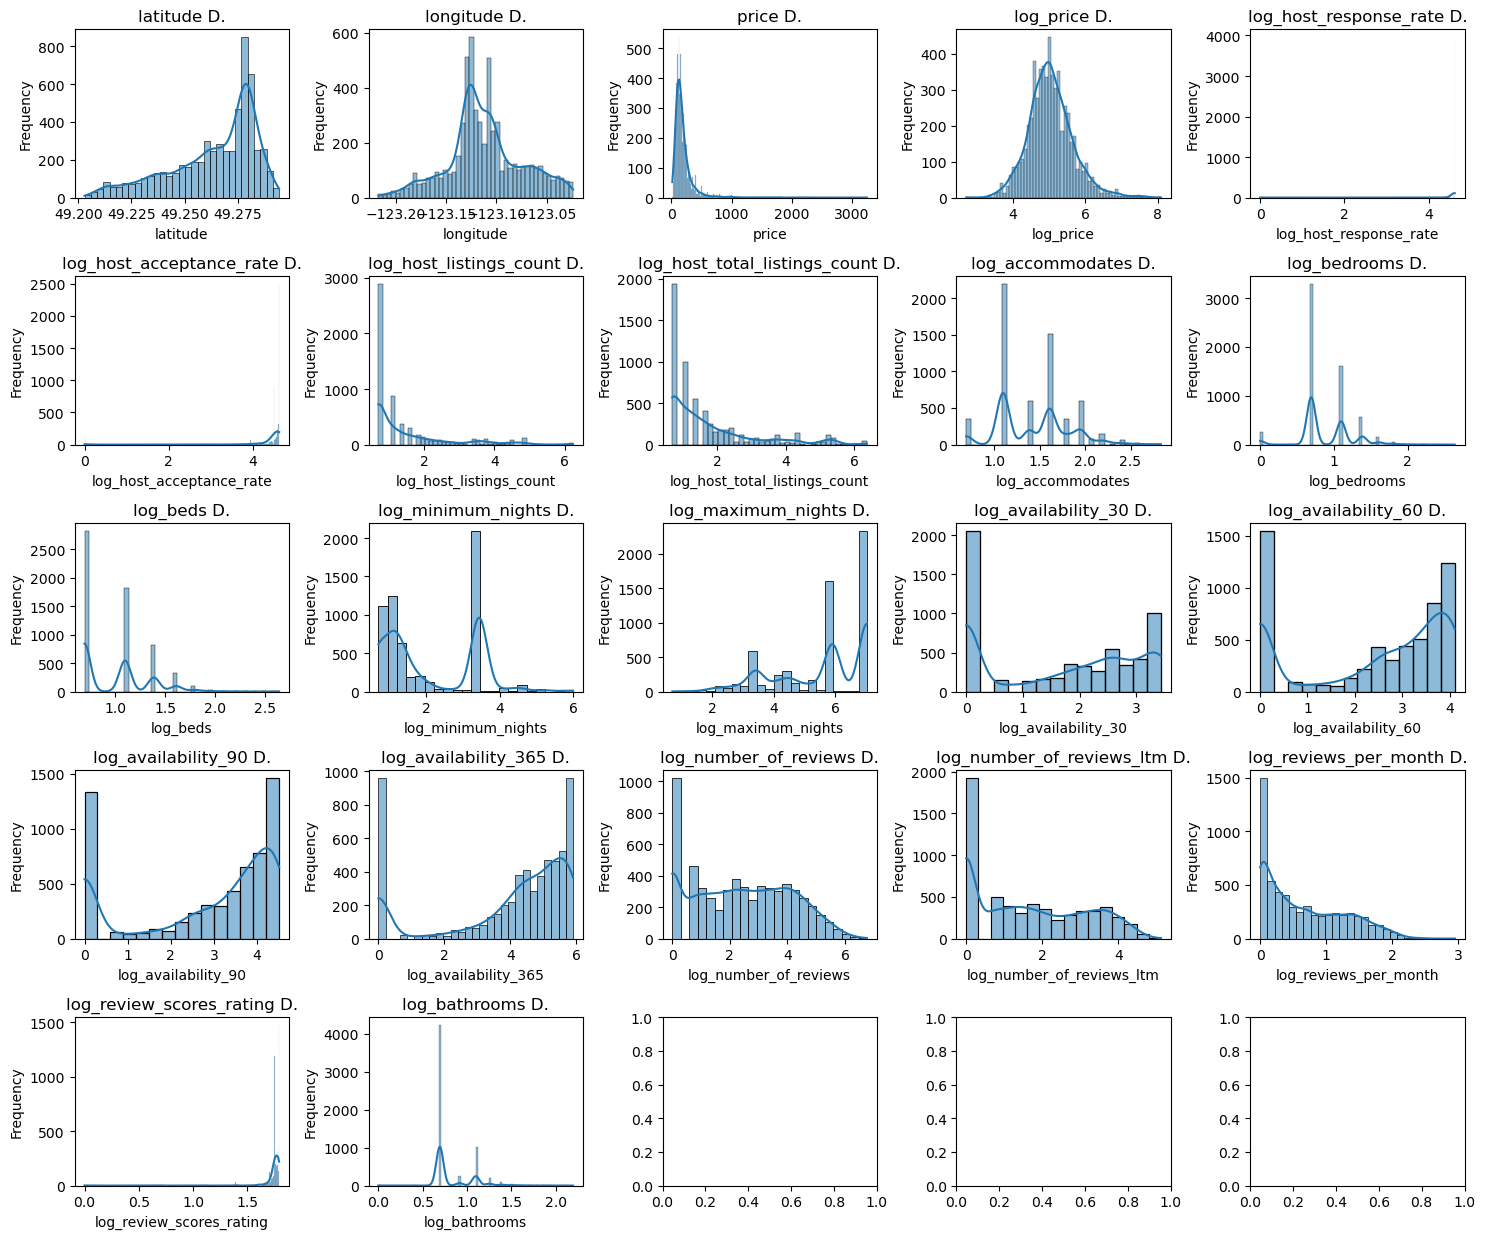

In [192]:
#Recreating newdf with changes in df_subset
newdf = df_subset.select_dtypes(include=numerics)

# Removing Binary columns
newdf = newdf.drop(binary_columns, axis=1)

# Creating visual
num_columns = len(newdf.columns)
num_rows = (num_columns + 4) // 5  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 2.5))  # Adjusting figsize

for i, column in enumerate(newdf.columns):
    row = i // 5  # Determine the row index for the subplot
    col = i % 5  # Determine the column index for the subplot

    sns.histplot(data=newdf[column], kde=True, ax=axes[row, col])  # Specify the subplot axes
    axes[row, col].set_title(f"{column} D.")
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()  # Adjusting spacing between subplots
plt.show()



# <a id='toc7_'></a>[6. Save Transformations](#toc0_)

In [193]:
# The next point is an extensive request, so I'd rather save before this
df_subset.to_csv('../../GitHub/Capstone/2_eda_airbnb_vancouver.csv', index=False)


# <a id='toc6_'></a>[5. Linearity between LogPrice and NumColumns](#toc0_)

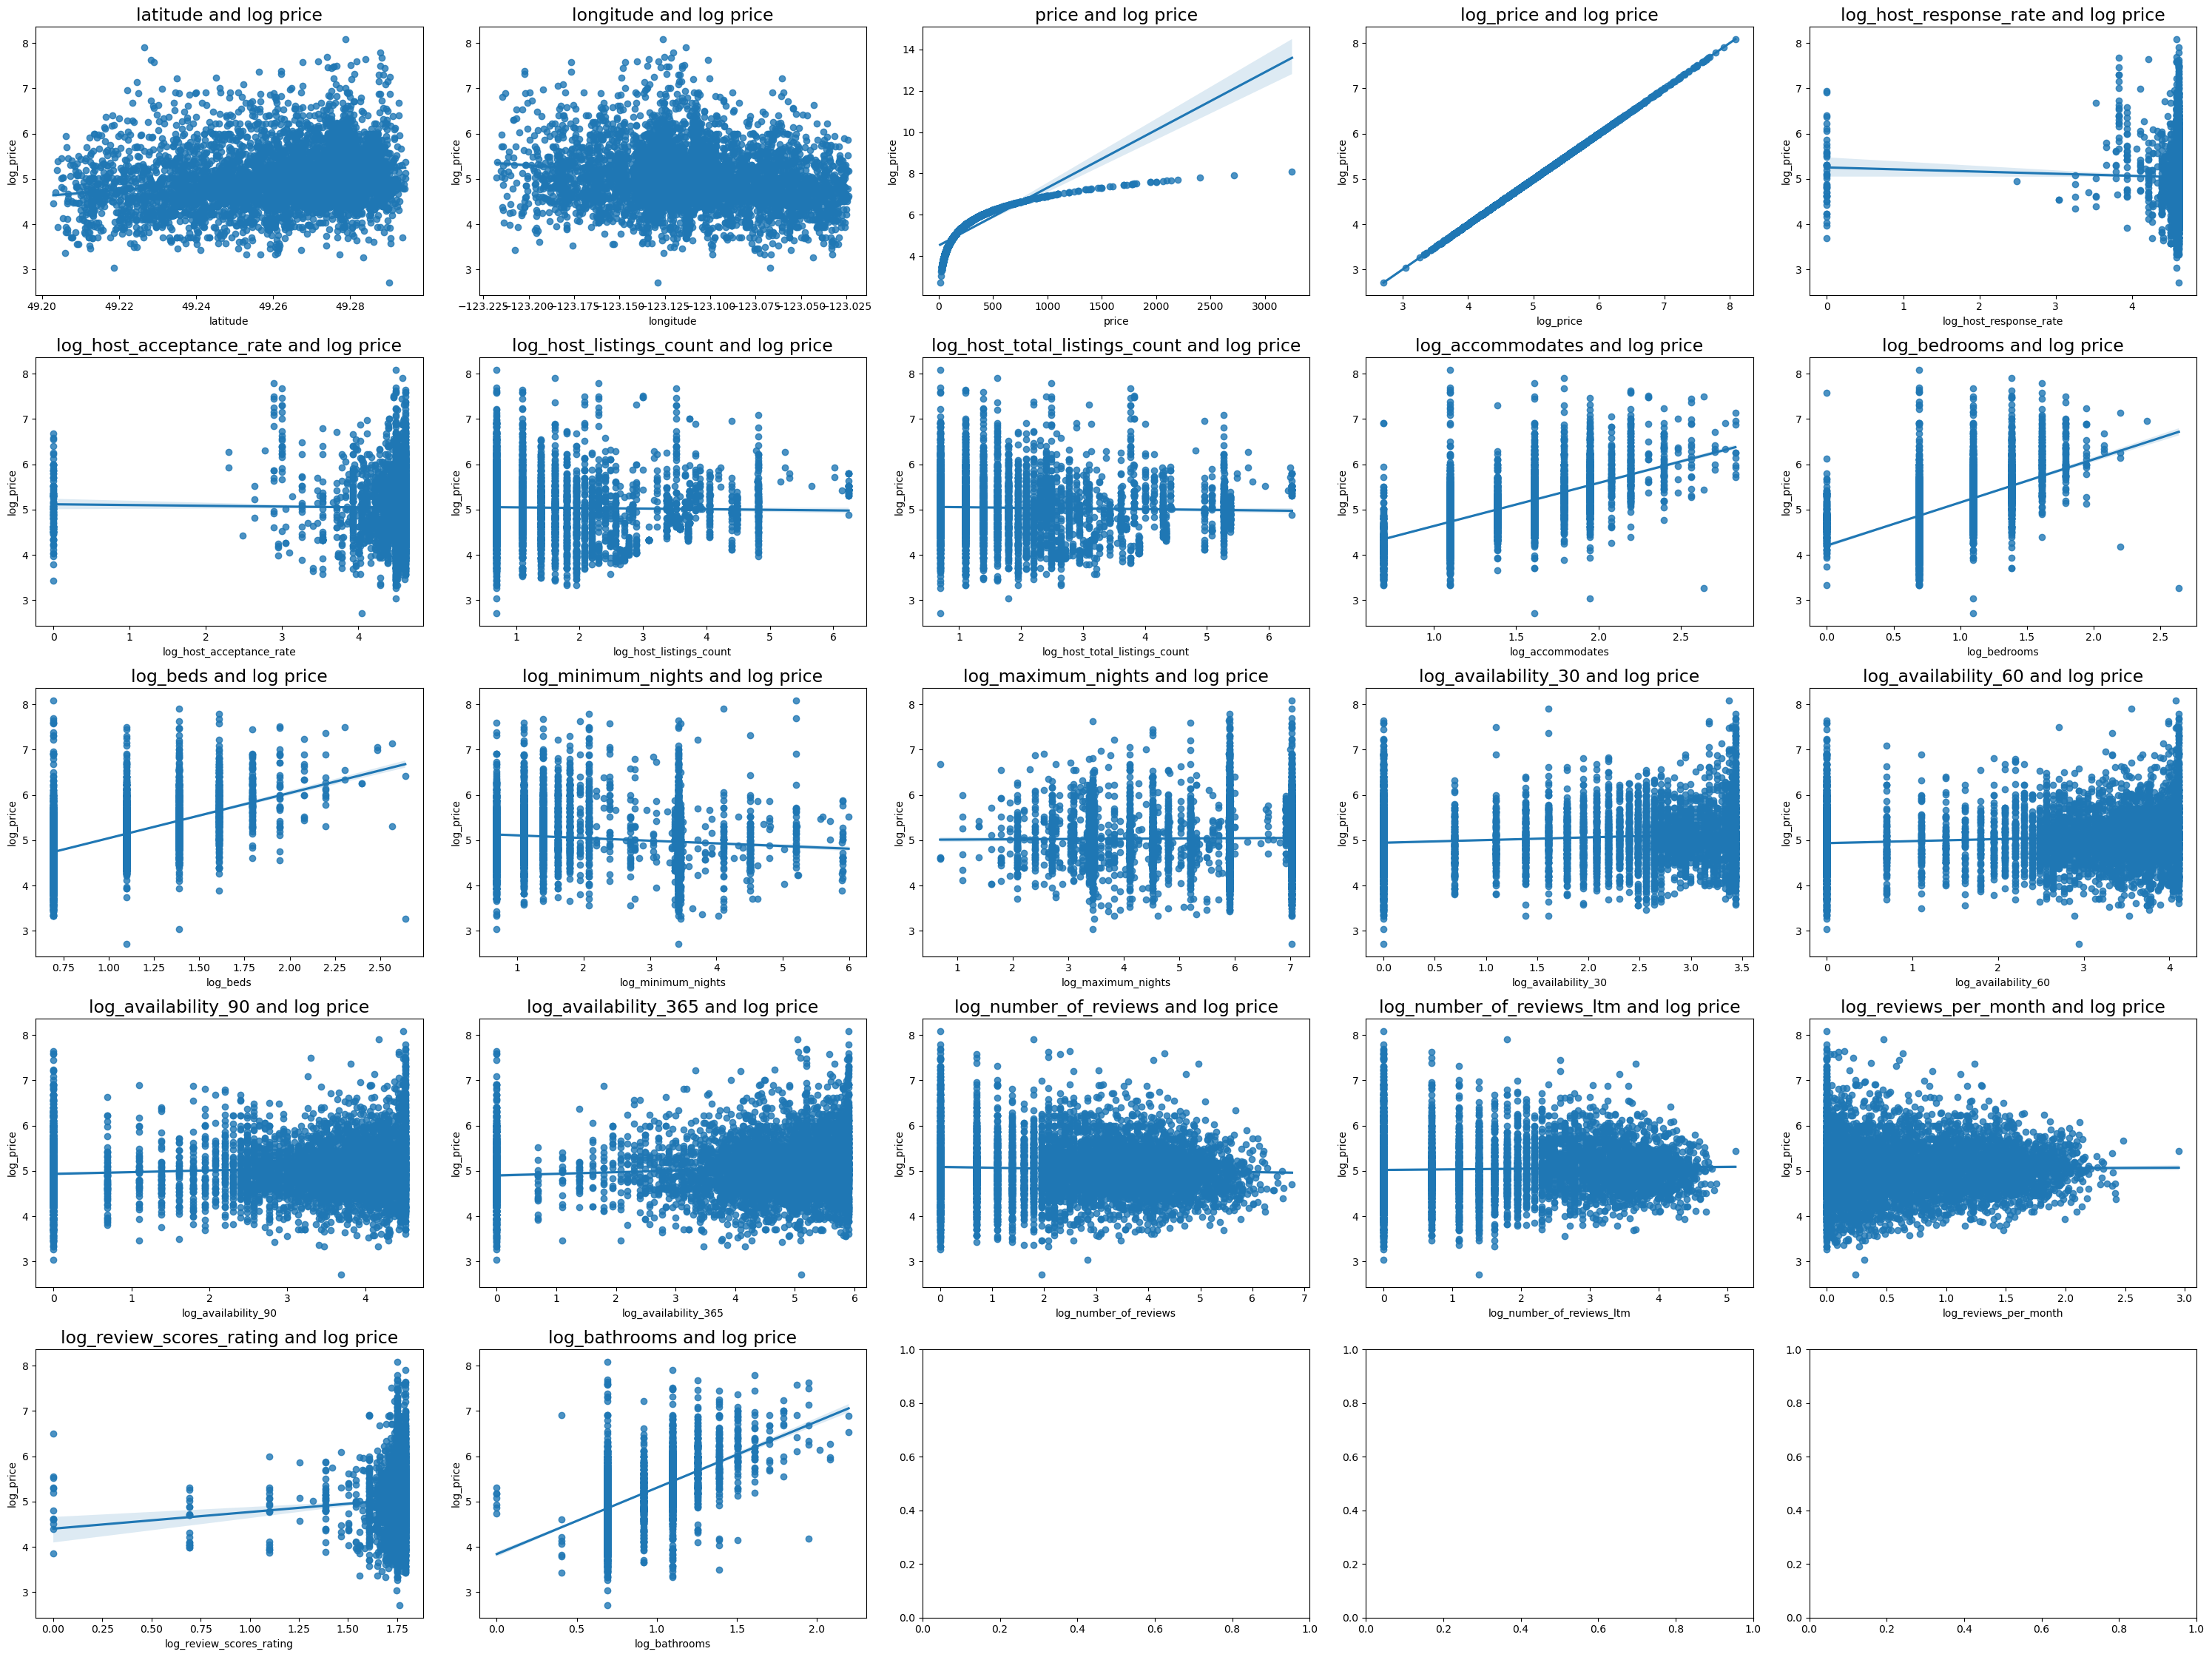

In [194]:
# Creating visual
num_columns = len(newdf.columns)
num_rows = (num_columns + 4) // 5  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 5, figsize=(30, num_rows * 4.5))  # Figsize

for ax, name in zip(axes.flatten(), newdf.columns):
  
  sns.regplot(x=name, y='log_price', data=newdf, ax=ax)
  ax.set_title(f"{name} and log price", fontsize=17)

plt.tight_layout()  # Adjusting spacing between subplots
plt.show()


We can see that most of the variable only have a 'light' linearity with the dependant variable log price. This is against one of the assumption of a Linear Regression. While it does not stop us from doing it, it signifies that the accuracy of the model will be impacted.


# <a id='toc8_'></a>[7. Key Findings](#toc0_)

Price variability is significant within the Airbnb listings in Vancouver, which can be attributed to factors such as the number of rooms and the type of property location (private, shared room, etc.). Due to the dataset being predominantly composed of private rooms and entire homes, our analysis focused exclusively on these types of accommodations.

To mitigate the impact of outliers and reduce variance, we applied the 3-sigma rule, a statistical guideline that identifies data points falling beyond three standard deviations from the mean. By removing such outliers, the dataset became more manageable, although some outliers may still be present based on observations from the box plot.

A large majority of prices tend to cluster around $100, and the price distribution does not follow a normal distribution.

Regarding the daily availability of rooms throughout the year, the range spans from 0 to 365 days across all neighborhoods. However, the distribution varies significantly across neighborhoods. Both entire homes and private rooms exhibit relatively comparable daily availability per year.

Downtown has the highest number of Airbnb listings, followed by Kitsilano, Mount Pleasant/False Creek, Riley Park, and Grandview-Woodland. Downtown also commands the highest prices for private bedrooms, while the West End features the most expensive entire homes. In general, West Point Grey stands out as the neighborhood with the highest prices across all types of accommodations.

After dividing Vancouver into four regions (Downtown, West, East, South), we found that many of the higher-priced listings are concentrated in Downtown and the West Side. On average, studios on the West Side have higher prices compared to Downtown, while one-bedroom units are relatively more affordable in Downtown. Interestingly, for 2-3 bedroom properties, the East Side offers prices that are relatively close to those on the West Side. This could be influenced by the pricing patterns in Mount Pleasant, where 2-bedroom and private home listings command the highest prices despite being categorized under the East Side.

We observed that hosts tend to lower their prices when they receive low review scores. It is worth noting that most Airbnb listings in Vancouver have high ratings, but there is still significant price variation among them.

Furthermore, we found that the price distribution exhibits a right-skewed pattern, indicating positive skewness. To address this, we will employ log transformations to reduce the skewness of the price variable. Similarly, variables displaying skewness will also undergo logarithmic transformations. These adjustments facilitate easier interpretation and improve statistical analysis.

Additionally, when examining the correlation between the log price and the other variables (transformed to logarithmic), we observe a limited linear relationship. This finding highlights the potential impact on the accuracy of a linear regression model, indicating the need for careful consideration and potential exploration of alternative modeling techniques.